In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import pickle

In [45]:
df = pd.read_csv('../Data/02_sub_reddit_data_clean.csv')

In [46]:
df.dtypes

id                      object
subreddit               object
title                   object
utc_datetime_str        object
num_comments             int64
day_name                object
title_word_count         int64
negative_score         float64
neutral_score          float64
positive_score         float64
compound_score         float64
removed_by_category     object
is_removed               int64
dtype: object

In [47]:
df.head(2)

,id,subreddit,title,utc_datetime_str,num_comments,day_name,title_word_count,negative_score,neutral_score,positive_score,compound_score,removed_by_category,is_removed
0,z99f3w,AskMen,what do athlete think about having some things...,2022-12-01 01:03:02,21,Thursday,12,0.0,0.859,0.141,0.2023,NaN,0
1,z991l7,AskMen,Why is the idea of permanent sleep so appealing?,2022-12-01 00:47:36,38,Thursday,9,0.0,1.000,0.000,0.0000,deleted,1


In [48]:
X=df['title']
y=df['subreddit']

In [49]:
baseline = y.value_counts(normalize=True)
baseline

AskWomen    0.504575
AskMen      0.495425
Name: subreddit, dtype: float64

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=.25, stratify=y)

In [117]:
def scores(y_test, preds):
'''
This function will be used to evaluate the score of our model.
'''
    print(f'Recall Score: {recall_score(y_test, preds, average="macro")}')
    print(f'F1 score: {f1_score(y_test, preds, average="macro")}')
    print(f'precision score: {precision_score(y_test, preds, average="macro")}')
    print(f'accuracy score: {accuracy_score(y_test, preds)}')

# Random forest with CountVectorizer

In [51]:
pipe_rf = Pipeline([
    ('cvec', CountVectorizer())
    ,('rt', RandomForestClassifier())
])

In [52]:
cross_val_score(pipe_rf, X_train, y_train, cv=3).mean()

0.6852605074569049

In [53]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('rt', RandomForestClassifier())])

In [54]:
print(f' Training score is {pipe_rf.score(X_train, y_train)}')
print(f' Test score is {pipe_rf.score(X_test, y_test)}')

 Training score is 0.9961262831687003
 Test score is 0.7049941927990708


In [55]:
pipe_rf_params = {
    'cvec__lowercase': [True],
    'cvec__max_features': [30, 50, 75.],
    'cvec__min_df': [2, 3, 9],
    'cvec__max_df': [0.80, 0.90],
    'cvec__ngram_range': [(1, 2), (2,3), (3,4)],
    'cvec__stop_words' : ['english', None],
    'rt__min_samples_leaf': [3, 5, 6],
    'rt__max_depth': [10, 15, 20],
    'rt__bootstrap': [True]
    
}

In [56]:
gs_rf = GridSearchCV(pipe_rf,
                 param_grid=pipe_rf_params,
                 cv=5, n_jobs = -1)

In [ ]:
gs_rf.fit(X_train, y_train)

In [58]:
display(gs_rf.best_params_)

{'cvec__lowercase': True,
 'cvec__max_df': 0.9,
 'cvec__max_features': 50,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'rt__bootstrap': True,
 'rt__max_depth': 15,
 'rt__min_samples_leaf': 6}

Best parmas for a countvector and random forest

|Param|setting|
|-----|-----|
|cvec_lowercase|True|
|cvec__max_df| .9|
|cvec__max_features| 50|
|cvec__min_df| 9|
|cvec__ngram_range| (1, 2)|
|cvec__stop_words| None|
|rt__bootstrap| True|
|rt__max_depth| 10|
|rt__min_samples_leaf| 6|

In [59]:
print(f' Training score is {gs_rf.score(X_train, y_train)}')
print(f' Test score is {gs_rf.score(X_test, y_test)}')

 Training score is 0.7135386403253922
 Test score is 0.6922183507549361


In [60]:
gs_rf.score(X_train, y_train)

0.7135386403253922

In [61]:
gs_rf.score(X_test, y_test)

0.6922183507549361

In [62]:
preds_rf = gs_rf.predict(X_test)

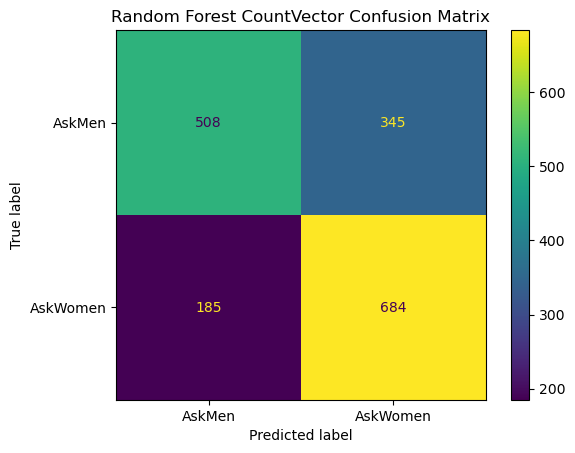

In [63]:
rf_matrix = ConfusionMatrixDisplay.from_estimator(gs_rf, X_test, y_test)
rf_matrix.ax_.set_title("Random Forest CountVector Confusion Matrix")
plt.savefig('../Figures/confusion_matrix/rf_cvec_confusion_matrix')

In [119]:
scores(y_test, preds_rf)

Recall Score: 0.6913283786864745
F1 score: 0.6889692561244423
precision score: 0.698883882557352
accuracy score: 0.6922183507549361


In [65]:
rf_model_1 = gs_rf

In [66]:
with open('../Models/model_pickel1.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(rf_model_1, pickle_out)

This model does better than baseline, but is slightly overfit. It also has a misclassified ~33% of the predictions for Askwomen and ~27% of the predictions for Askmen. With a recall score and accuracy score of 69% this model does okay, but is not suitable for large scale use.

# Logistic regresion with countvectorizor

In [67]:
pipe_logr = Pipeline([
    ('cvec', CountVectorizer())
    ,('logr', LogisticRegression())
])

In [ ]:
pipe_logr.fit(X_train, y_train)

In [69]:
pipe_logr.score(X_train, y_train)

0.8894053844663955

In [70]:
pipe_logr.score(X_test, y_test)

0.6782810685249709

In [71]:
pipe_logr_params = {
    'cvec__lowercase': [True],
    'cvec__max_features': [30, 50, 75.],
    'cvec__min_df': [2, 3, 9],
    'cvec__max_df': [0.80, 0.90],
    'cvec__ngram_range': [(1, 2), (2,3), (3,4)],
    'cvec__stop_words' : ['english', None],
    'logr__C':[.25, .5, .75, 1]
}

In [72]:
gs_logr = GridSearchCV(pipe_logr, param_grid=pipe_logr_params, cv=3,n_jobs=-1)

In [ ]:
gs_logr.fit(X_train,y_train)

In [74]:
display(gs_logr.best_params_)

{'cvec__lowercase': True,
 'cvec__max_df': 0.8,
 'cvec__max_features': 30,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'logr__C': 0.25}

Best parmas for a countvector and logistic regression

|Param|setting|
|-----|-----|
|cvec__lowercase|True|
|cvec__max_df| .8|
|cvec__max_features| 30|
|cvec__min_df| 2|
|cvec__ngram_range| (1, 2)|
|cvec__stop_words| None|
|logr_C| .25|


In [75]:
gs_logr.score(X_train, y_train)

0.6529149719155529

In [76]:
gs_logr.score(X_test,y_test)

0.6637630662020906

After adding the penality term, the logistic regression was much less fit. The performance is similar to our random forest which was overfit, so this model may be better. We will have to see its recall score to compare.

In [77]:
preds_logr = gs_logr.predict(X_test)

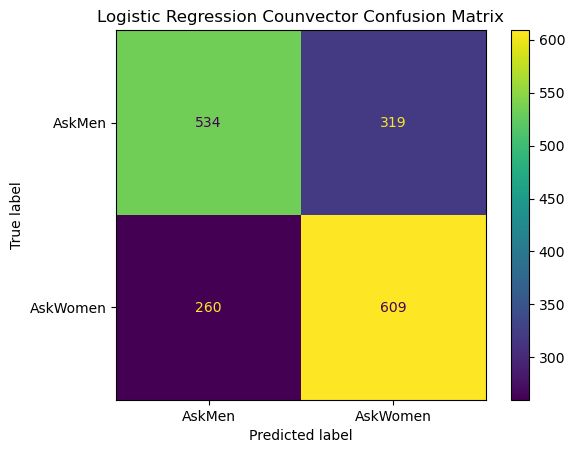

In [78]:
log_matrix = ConfusionMatrixDisplay.from_estimator(gs_logr, X_test, y_test)
log_matrix.ax_.set_title("Logistic Regression Counvector Confusion Matrix")
plt.savefig('../Figures/confusion_matrix/logr_cvec_confusion_matrix')

In [120]:
scores(y_test, preds_logr)

Recall Score: 0.663415657457535
F1 score: 0.6631240288154818
precision score: 0.664397040302267
accuracy score: 0.6637630662020906


Here we notice a 3% lower recall score, which is not much of an difference. This model is better at predicting Askmen, but does worse with Askwomen. In this case the model is making more predictions for Askmen, so any increase is negligible. Next we will see if using the TFIDF Vectorizer will improve performance. In theory it should perform better because its comparing the title (document) to the whole subreddit (corpus).

# Random forest with TF-IDF Vectorizer 

In [80]:
pipe_rf_tf = Pipeline([
    ('tf',TfidfVectorizer())
    ,('rt', RandomForestClassifier())
])

In [81]:
cross_val_score(pipe_rf_tf, X_train, y_train, cv=3).mean()

0.6813867906256053

In [82]:
pipe_rf_tf.fit(X_train, y_train)

Pipeline(steps=[('tf', TfidfVectorizer()), ('rt', RandomForestClassifier())])

In [83]:
print(f' Training score is {pipe_rf_tf.score(X_train, y_train)}')
print(f' Test score is {pipe_rf_tf.score(X_test, y_test)}')

 Training score is 0.9961262831687003
 Test score is 0.7113821138211383


In [84]:
pipe_rf_tf_params = {
    'tf__lowercase': [True],
    'tf__max_features': [30, 50, 75.],
    'tf__min_df': [2, 3, 9],
    'tf__max_df': [0.80, 0.90],
    'tf__ngram_range': [(1, 2), (2,3), (3,4)],
    'tf__stop_words' : ['english', None],
    'rt__min_samples_leaf': [3, 5, 6],
    'rt__max_depth': [10, 15, 20],
    'rt__bootstrap': [True]
    
}

In [85]:
gs_rf_tf = GridSearchCV(pipe_rf_tf, param_grid=pipe_rf_tf_params, cv=3, n_jobs=-1)

In [ ]:
gs_rf_tf.fit(X_train, y_train)

In [87]:
gs_rf_tf.best_params_

{'rt__bootstrap': True,
 'rt__max_depth': 10,
 'rt__min_samples_leaf': 6,
 'tf__lowercase': True,
 'tf__max_df': 0.9,
 'tf__max_features': 50,
 'tf__min_df': 2,
 'tf__ngram_range': (1, 2),
 'tf__stop_words': None}

Best parmas for a TFID and random forest

|Param|setting|
|-----|-----|
|tf__max_df| .9|
|tf__max_features| 30|
|tf__min_df| 3|
|tf__ngram_range| (1, 2)|
|tf__stop_words| None|
|tf__lowercase| True|
|rt__bootstrap| True|
|rt__max_depth| 10|
|rt__min_samples_leaf| 6|

In [88]:
print(f' Training score is {gs_rf_tf.score(X_train, y_train)}')
print(f' Test score is {gs_rf_tf.score(X_test, y_test)}')

 Training score is 0.7162502421073019
 Test score is 0.6742160278745645


It appears the model did not improve much with the classification rate after incorporating the TFIDF. We will see if it has a recall score to when we used the countvectorizer

In [89]:
preds_rf_tf = gs_rf_tf.predict(X_test)

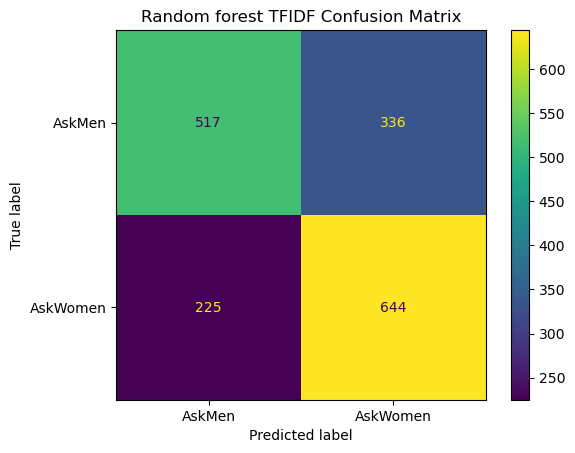

In [90]:
rf_tf_matrix = ConfusionMatrixDisplay.from_estimator(gs_rf_tf, X_test, y_test)
rf_tf_matrix.ax_.set_title("Random forest TFIDF Confusion Matrix")
plt.savefig('../Figures/confusion_matrix/Random_forest_tfidf_confusion_matrix')

In [121]:
scores(y_test, preds_rf_tf)

Recall Score: 0.6735889172041546
F1 score: 0.6724343074541691
precision score: 0.6769541778975741
accuracy score: 0.6742160278745645


Her we see a similar recall score (.67~) compared to our random forest and counvectorizer (.69). There's not much of an improvement here, the subreddits may be too similar to differentiate. We will see if there's any improvement with our logistical regression using a TF-IDF vectorizer.

# Logistic regression with TF-IDF Vectorizer 

In [92]:
pipe_logr_tf = Pipeline([
    ('tf', TfidfVectorizer())
    ,('logr', LogisticRegression())
])

In [93]:
pipe_logr_tf_params = {
    'tf__lowercase': [True],
    'tf__max_features': [30, 50, 75.],
    'tf__min_df': [2, 3, 9],
    'tf__max_df': [0.80, 0.90],
    'tf__ngram_range': [(1, 2), (2,3), (3,4)],
    'tf__stop_words' : ['english', None],
    'logr__C':[.25, .5, .75, 1]
}

In [94]:
cross_val_score(pipe_logr_tf, X_train, y_train, cv=3).mean()

0.6668603525082316

In [95]:
gs_logr_tf = GridSearchCV(pipe_logr_tf, param_grid=pipe_logr_tf_params, cv=3, n_jobs=-1)

In [96]:
pipe_logr_tf.fit(X_train, y_train)

Pipeline(steps=[('tf', TfidfVectorizer()), ('logr', LogisticRegression())])

In [97]:
print(f' Training score is {pipe_logr_tf.score(X_train, y_train)}')
print(f' Test score is {pipe_logr_tf.score(X_test, y_test)}')

 Training score is 0.8332364904125509
 Test score is 0.6927990708478513


In [ ]:
gs_logr_tf.fit(X_train, y_train)

In [99]:
print(f' Training score is {gs_logr_tf.score(X_train, y_train)}')
print(f' Test score is {gs_logr_tf.score(X_test, y_test)}')

 Training score is 0.6560139453805927
 Test score is 0.6695702671312428


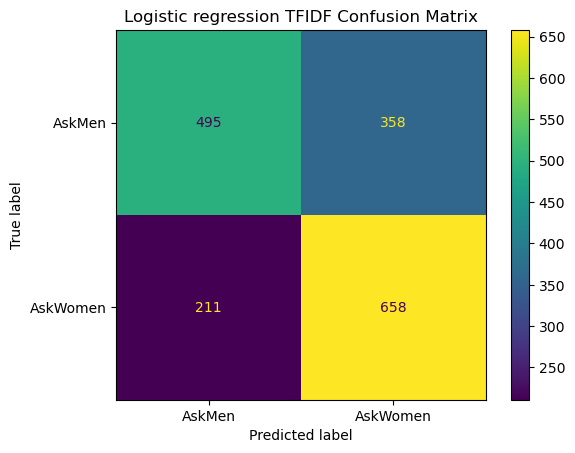

In [100]:
logr_tf_matrix = ConfusionMatrixDisplay.from_estimator(gs_logr_tf, X_test, y_test)
logr_tf_matrix.ax_.set_title("Logistic regression TFIDF Confusion Matrix")
plt.savefig('../Figures/confusion_matrix/Logistic_tfidf_confusion_matrix')

In [101]:
preds_logr_tf = gs_logr_tf.predict(X_test)

In [122]:
scores(y_test, preds_logr_tf)

Recall Score: 0.6687484907393793
F1 score: 0.6665828431814587
precision score: 0.6743854698757556
accuracy score: 0.6695702671312428


Again we notice a slight improvement in predicting Askwomen, but that is only because it is making more Askwomen predictions. Overall these models are performing with the same accuracy. Any modifications only results in a slightly higher true positive for one subreddit, but again that was only due to the model making more predictions for that sub reddit.

# Conclusion

Here we built 2 models using 2 different transformers. We used the models logistic regression and random forest with the transformers Countvectorizer and TFIDF transformers. In out findings we found consistent recall scores within the 60% ranges. Our models were pretty consistent with our classifications and changing the model or transformer had marginal differences in the models performance. 

Even with modifying the n_gram ranges of our transformers, the best parameter seemed to be 1 to 2 word grams. According to our EDA process, the most popular topics within these subreddits are too common so there will be some misclassification. Our model only does slightly better than our baseline score of 50% Askwomen and 49% Askmen. Because of the small difference in performance these models are not usable for research purposes. These subreddits may be too similar and we are unable to get more accuracy at this time.

# Recommendations

With our current models we cannot accurately predict which subreddit a post belongs too. For future revisions, one thing we can do is removed the top common words used in each subreddits to better differentiate them.

Experiment with a model that has no post that have been removed, this can potentially be more representative of the respective subreddits.  

Another model we can build is a model to automatically identify post that should be removed. Because about 60% of our initial data was been removed we can use that as training data to build a model. We can do this by identifying what key terms in removed titles, and hopefully predict the probability of being classified as a removed post.

# Limitations

1) Too many removed post, almost half of our post were removed, so those post were potentially not representative of the subreddit.

2) The subreddits were too similar, when looking at the distribution of some of the features we fond most of them to have similar distributions.

3) The subreddits are question based, so there is little room for distinguishing features.
